In [1]:
#Load packages
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd 
import torch.nn.functional as F

## Load data

In [2]:
#Import data 
train_data_without = pd.read_csv('../Data/training.csv')
test_data = pd.read_csv('../Data/test.csv')
id_lookup_data = pd.read_csv('../Data/IdLookupTable.csv')
train_data = pd.read_csv('../Data/training_with_aug.csv')

In [3]:
#Delete unused axis
train_data = train_data.drop('Unnamed: 0', axis = 1)

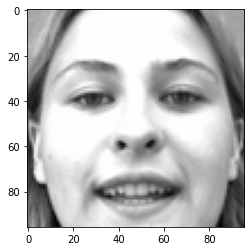

In [9]:
#Helper functions found from: https://www.kaggle.com/code/james146/facial-keypoints-detection-pytorch 
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    #plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)
    
show_image_with_keypoints_by_id(train_data, 7)

## Data preprocessing

In [5]:
#Shuffels dataset
train_data = train_data.sample(n = len(train_data))


## Model

In [6]:
#Convert dataset for training

class imageDataset(Dataset):
    def __init__(self, file_name):
        labels=[file_name.iloc[i].values[0:30] for i in range(len(train_data))]
        inputs=[file_name.iloc[i].values[30:31] for i in range(len(train_data))]

        inputs = [(i[0].split()) for i in inputs]
        inputs = [[int(i) for i in j] for j in inputs] 
        inputs = [np.reshape(i, (96,96)) for i in inputs]
        inputs = [np.expand_dims(i,0) for i in inputs]

        self.labels=torch.tensor(labels,dtype=torch.float32) 
        self.inputs=torch.tensor(inputs, dtype=torch.float) 
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [7]:
#Define dataset 
data = imageDataset(train_data)

<ipython-input-6-691cbf15e6af>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  self.labels=torch.tensor(labels,dtype=torch.float32)


In [8]:
#Define training data as tensor dataset 
batch_size = 100

x_train = data.inputs
y_train = data.labels

trainset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

### Network Architecture 

In [9]:
#Makeing network with inspiration from: 
num_classes = 30

#Define network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.relu
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16,kernel_size=3,padding='same')
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256,kernel_size=5)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=1024,kernel_size=3)
        self.bn4 = nn.BatchNorm2d(1024)
        
        self.fc1 = nn.Linear(9216, 1024)
        self.FC1 = nn.Linear(1024, 256)  
        self.FC2 = nn.Linear(256, num_classes)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = F.max_pool2d(x, kernel_size=2)
    
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = F.relu(x)
        x = self.bn4(x)
        
        x = x.view(x.shape[0],-1)
        
        x = self.fc1(x)

        x = self.FC1(x)
        x = self.FC2(x)
        
        return x

net = NeuralNetwork()

### Training the Network

In [10]:
#Define parameters 
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nEpocs = 30 
totaliter = 0
net.train()
for epoch in range(nEpocs):  #Loop over the dataset multiple times
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        totaliter+=1
        
        #Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #Zero the parameter gradients
        optimizer.zero_grad()

        #Forward + backward + optimize      
        outputs = net(inputs)
        outputs_reshape = outputs.view(outputs.shape[0],-1)
        loss = criterion(outputs_reshape, labels)
        loss.backward()
        optimizer.step()

        #Print Loss
        running_loss += loss.item()
        

    print('Epoch %d, Train loss: %.3f' %(epoch + 1, running_loss / 100))
            
    running_loss = 0.0
print('Finished Training')
net.eval()

Epoch 1, Train loss: 150.549
Epoch 2, Train loss: 36.619
Epoch 3, Train loss: 28.061
Epoch 4, Train loss: 21.101
Epoch 5, Train loss: 17.030
Epoch 6, Train loss: 15.748
Epoch 7, Train loss: 12.650
Epoch 8, Train loss: 11.421
Epoch 9, Train loss: 9.641
Epoch 10, Train loss: 9.808
Epoch 11, Train loss: 8.719
Epoch 12, Train loss: 6.577
Epoch 13, Train loss: 4.721
Epoch 14, Train loss: 3.813
Epoch 15, Train loss: 3.617
Epoch 16, Train loss: 2.682
Epoch 17, Train loss: 2.535
Epoch 18, Train loss: 1.993
Epoch 19, Train loss: 2.034
Epoch 20, Train loss: 2.246
Epoch 21, Train loss: 1.882
Epoch 22, Train loss: 2.521
Epoch 23, Train loss: 1.688
Epoch 24, Train loss: 1.635
Epoch 25, Train loss: 1.789
Epoch 26, Train loss: 1.493
Epoch 27, Train loss: 1.278
Epoch 28, Train loss: 1.218
Epoch 29, Train loss: 1.356
Epoch 30, Train loss: 1.164
Finished Training


NeuralNetwork(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (FC1): Linear(in_features=1024, out_fea

In [13]:
torch.save(net,'trained_model.pt')

## Predictions on Testset

In [11]:
#Preparing testdata for predictions 
image_lists = [np.array(list((map(float, test_data.iloc[i, -1].split(' '))))).reshape(96, 96) for i in range(len(test_data))]

In [60]:
#Run network on testdata 
test_images = [np.expand_dims(i,0) for i in image_lists]
#test_outputs = [net(torch.Tensor(i)) for i in test_images]
test_outputs = [net(torch.Tensor(test_images[i]).unsqueeze(0)) for i in range(len(test_data))]

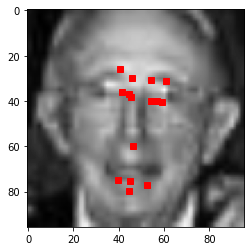

In [61]:
#See predictions of testdata 
def get_image_and_keypoints2(series,id):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(test_outputs[id].tolist()).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id2(test_data, id):
    series = test_data.iloc[id]
    return get_image_and_keypoints2(series,id)


def show_image_with_keypoints2(series,id):
    image, keypoints = get_image_and_keypoints2(series,id)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id2(test_data, id):
    series = test_data.iloc[id]
    show_image_with_keypoints2(series,id)
    
show_image_with_keypoints_by_id2(test_data, 1000)

### Apply filter 

In [62]:
import cv2

In [63]:
#Changed plots
def get_image_and_keypoints1(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = test_outputs.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id1(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints1(series)

def show_image_with_keypoints_by_id1(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints1(series)  

def show_image_with_keypoints1(series):
    image, keypoints = get_image_and_keypoints1(series)
    plt.imshow(image, cmap='gray')

In [80]:
# Prepare variables for the filter

#keypoints = y_train[0] (fra Filter.ipynb)
keypoints = test_outputs[1][0].tolist()
#keypoints = keypoints[0]

#img_copy = np.array(x_train[0]) (fra Filter.ipynb)
img_copy = np.array(test_images[1])

img_copy = np.reshape(img_copy, (96,96,1)) #(fra Filter.ipynb)

x_coords = keypoints[0::2]     
y_coords = keypoints[1::2]   

In [81]:
len(x_coords)

15

In [82]:
# Convert from grayscale to BGRA.

img_copy = np.float32(img_copy)
img_copy = np.array(img_copy)

img_copy = cv2.cvtColor(img_copy, cv2.COLOR_GRAY2BGRA)

In [83]:
# Points used for placing the filters.
x_coords = list(x_coords)
left_brow_coords = (int(x_coords[7]), int(y_coords[7]))
right_brow_coords = (int(x_coords[9]), int(y_coords[9]))
nose_coords = (int(x_coords[10]), int(x_coords[10]))

In [84]:
# Apply the nose filter
nose_width = 10

nose_filter = cv2.imread('nose.png', -1)
nose_filter = cv2.resize(nose_filter, (nose_width*2,20))
sw,sh,sc = nose_filter.shape


for i in range(0,sw):
    for j in range(0,sh):
        if nose_filter[i,j][3] != 0:
            img_copy[nose_coords[0]+i-8, nose_coords[1]+j-8] = nose_filter[i,j]

In [85]:
# Apply Antlers filter on the image.
antlers_width = left_brow_coords[0] - right_brow_coords[0]

antlers_filter = cv2.imread('antlers.png', -1)
antlers_filter = cv2.resize(antlers_filter, (antlers_width,35))
gw,gh,gc = antlers_filter.shape

for i in range(0,gw):
    for j in range(0,gh):
        if antlers_filter[i,j][3] != 0:
            img_copy[left_brow_coords[1]+i-28, right_brow_coords[0]+j] = antlers_filter[i,j]

In [86]:
img_copy = img_copy.astype(np.uint8)
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGRA2RGB)       # Revert back to RGB

In [87]:
def plot_sample1(image):
    image = image.reshape(96,96,3)
    fig, axis = plt.subplots()
    axis.imshow(image)
    plt.imshow((image).astype(np.uint8))

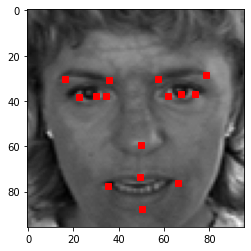

In [91]:
show_image_with_keypoints_by_id2(test_data, 1)

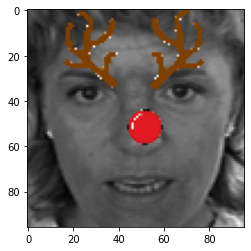

In [89]:
plot_sample1(img_copy)